# Model Trainig
## SQL Analysis Problem

In [ ]:

!wget https://github.com/claranet-coast/sql-analytics-problem/archive/master.zip
!unzip master.zip -d /project
!pip install -q tensorflow-text
!pip install -q tf-models-official

--2021-03-20 09:33:43--  https://github.com/claranet-coast/sql-analytics-problem/archive/master.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/claranet-coast/sql-analytics-problem/zip/master [following]
--2021-03-20 09:33:43--  https://codeload.github.com/claranet-coast/sql-analytics-problem/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [ <=>                ]   1020K  --.-KB/s    in 0.1s    

2021-03-20 09:33:44 (8.30 MB/s) - ‘master.zip’ saved [1044652]

Archive:  master.zip
6fa5ffb3f77882283c2bcd2c2545fb36dbefffdc
   creating: /project/sql-analytics-problem-master/
  infl

In [13]:
import pandas as pd
import json
import os
import re
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.model_selection import train_test_split
from gensim.models import FastText
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import GRU, Dense, Embedding,concatenate, Input, Dropout, Activation, GlobalAveragePooling1D, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential,Model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from keras import backend as K
from google.colab import files
from pickle import dump
import statistics

## Data Preprocessing
- remove text between */  */
- remove new line dedicated chars
- replace date, time, id and number dedicated strings by corresponding tags

The task covers regression analysis.<br>
The values of target variable is too small and eventually may lead to negative predictions.<br>
To avoid that logarithme transormation has been applied on the target variable. <br>
Predicted values are converted back to real scale using exponent function.

In [ ]:
def clean(s):
    s= re.sub('\s+', ' ', s)
    try:
        s=re.search(r'(.*)/(.*)',s).group(2)

    except:
        pass
    return s.lower()

def extendedClean(s):
    s= re.sub('\d{4}-\d{2}-\d{2}',"|date|",s)
    s= re.sub('\d{2}:\d{2}:\d{2}',"|time|",s)
    s= re.sub('\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}',"|datetime|",s)
    s= re.sub('\d{13}',"|datetime|",s)
    s= re.sub('\d{8,12}',"|id|",s)
    s= re.sub('\d{2,7}',"|number|",s)
    return s

with open('/project/sql-analytics-problem-master/data/slow_log.json') as json_file:
    data = json.load(json_file)
logData=pd.json_normalize(data)
preprocessed=logData['sql_text'].map(lambda x: clean(x))
preprocessed.head(5)

0        set net_write_timeout=600
1                    show warnings
2                    show warnings
3                select database()
4     set sql_select_limit=default
Name: sql_text, dtype: object

In [ ]:
y=logData['query_time'].map(lambda x: float(str(x)[6:]))
y.describe()
y= np.log(y)
y.describe()

count    15688.000000
mean        -4.772627
std          3.904049
min        -11.869600
25%         -7.724201
50%         -6.637348
75%         -0.617493
max          2.404548
Name: query_time, dtype: float64

# Support Vector Regressor
- Count word vectorizer
- SVR
- Crossvalidation

In [ ]:
prep= preprocessed.map(lambda x: extendedClean(x))
prep=prep.map(lambda x: x.replace(",", " , ").replace("("," ( ").replace(")"," ) ").replace("="," = "))
print(prep[0])
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,1))
X = vectorizer.fit_transform(prep)

 set net_write_timeout = |number|


In [ ]:
scaler=StandardScaler(with_mean=False)
X=scaler.fit_transform(X)
clf=SVR(C=1.0, epsilon=0.2)


scores = cross_val_score(clf, X, y, cv=5, scoring="neg_mean_squared_error")
scores

array([-2.60929857, -0.48768693, -1.02234861, -0.7812262 , -0.7548222 ])

In [16]:
print("Average MSE of SVR Model: " + str(statistics.mean([-2.60929857, -0.48768693, -1.02234861, -0.7812262 , -0.7548222 ])))


Average MSE of SVR Model: -1.131076502


In [ ]:
# custom keras metric to calculate MSE on real data
def metr(y_true, y_pred):
  '''custom MSE to monitor real data'''
  return K.mean(K.square(K.exp(y_pred)- K.exp(y_true)))

es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True)
epochs = 50


## BERT model training

BERT model requires row input 

In [ ]:
#for bert
X_train, X_test, y_train, y_test = train_test_split(preprocessed, y, test_size=0.25, random_state=42)

In [ ]:
bert_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',name="preprocess")
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',name="network")

In [ ]:
def build_bert():
  text_input = Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = bert_preprocess
  encoder_inputs = preprocessing_layer(text_input)
  encoder = bert_model
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  #net = tf.keras.layers.Dense(128,activation="relu", name='net')(net)
  net = Dropout(0.2)(net)
  net = Dense(1, activation="linear", name='output')(net)
  return Model(text_input, net)

bert = build_bert()
bert.summary()
bert.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),loss="mse",metrics=[metr])


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
network (KerasLayer)            {'input_word_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
preprocess (KerasLayer)         {'encoder_outputs':  109482241   network[1][0]                    
                                                                 network[1][1]                    
                                                                 network[1][2]                    
____________________________________________________________________________________________

In [ ]:
hist= bert.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),epochs=epochs, callbacks=[es])

Epoch 1/50
368/368 [==============================] - 160s 410ms/step - loss: 8.1320 - metr: 1.5036 - val_loss: 2.8952 - val_metr: 1.4565
Epoch 2/50
368/368 [==============================] - 158s 430ms/step - loss: 3.1390 - metr: 1.7462 - val_loss: 2.2250 - val_metr: 1.5218
Epoch 3/50
368/368 [==============================] - 162s 440ms/step - loss: 2.6812 - metr: 2.0797 - val_loss: 1.8976 - val_metr: 1.4636
Epoch 4/50
368/368 [==============================] - 163s 442ms/step - loss: 2.3380 - metr: 1.9136 - val_loss: 1.6980 - val_metr: 1.3553
Epoch 5/50
368/368 [==============================] - 163s 444ms/step - loss: 2.1009 - metr: 1.9804 - val_loss: 1.5616 - val_metr: 1.2396
Epoch 6/50
368/368 [==============================] - 163s 443ms/step - loss: 1.9770 - metr: 1.8911 - val_loss: 1.4817 - val_metr: 1.2465
Epoch 7/50
368/368 [==============================] - 163s 444ms/step - loss: 1.9064 - metr: 1.8668 - val_loss: 1.4440 - val_metr: 1.1602
Epoch 8/50
368/368 [==============

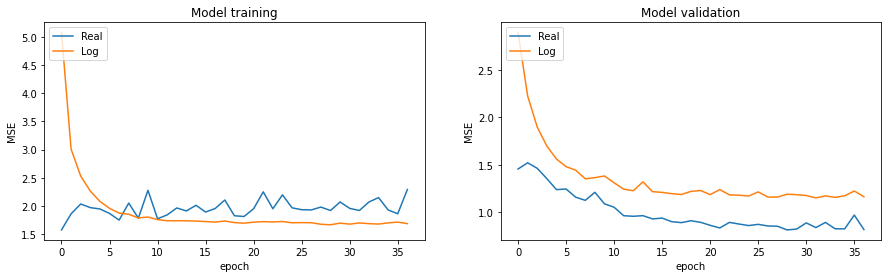

In [ ]:
fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot2grid((1,2),(0,0))
ax1.plot(hist.history['metr'])
ax1.plot(hist.history['loss'])
ax1.set_title('Model training')
ax1.set_ylabel('MSE')
ax1.set_xlabel('epoch')
ax1.legend(['Real', 'Log'], loc='upper left')

ax1 = plt.subplot2grid((1,2),(0,1))
ax1.plot(hist.history['val_metr'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('Model validation')
ax1.set_ylabel('MSE')
ax1.set_xlabel('epoch')
ax1.legend(['Real', 'Log'], loc='upper left')
plt.show()

## RNN + FastText embeddings training

- FastText embeddings
- RNN model

Additional preprocessing to keep  , ( ) = chars as separate words

In [ ]:
maxlen= max([len(i.split()) for i in preprocessed])
#extendedClean
addPreproc= preprocessed.map(lambda x: extendedClean(x))
addPreproc=addPreproc.map(lambda x: x.replace(",", " , ").replace("("," ( ").replace(")"," ) ").replace("="," = "))
tokenized=[tf.keras.preprocessing.text.text_to_word_sequence(i,filters='') for i in addPreproc]
tokenized[10:15]


[['ping'],
 ['ping'],
 ['select', '@@global.read_only'],
 ['select', '1'],
 ['select', 'value', 'from', 'mysql.rds_heartbeat2']]

In [ ]:
modEmbed = FastText(tokenized, size=300, window=5, min_count=1, workers=4, word_ngrams=1)
#words = list(modEmbed.wv.vocab)
print(modEmbed)
#modEmbed.train(prepped,total_examples=len(prepped),epochs=3, verbose=1)
embedding_matrix = np.zeros((len(modEmbed.wv.vocab) + 1, 300))
for i, vec in enumerate(modEmbed.wv.vectors):
    embedding_matrix[i] = vec


FastText(vocab=658, size=300, alpha=0.025)


In [ ]:
features = embedding_matrix.shape[0]
tokenizer = Tokenizer(num_words = features)
# fit the tokenizer on our text

tokenizer.fit_on_texts(addPreproc)

print(addPreproc[0])
# get all words that the tokenizer knows
word_index = tokenizer.word_index

# put the tokens in a matrix
X = tokenizer.texts_to_sequences(addPreproc)
print(X[0])
X = pad_sequences(X)
print(X.shape)
print(X[0])



 set net_write_timeout = |number|
[139, 320, 312, 303, 7]
(15688, 244)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [ ]:
inp = Input(shape=(X.shape[1], ))
emb=Embedding(len(modEmbed.wv.vocab)+1 ,300,weights=[embedding_matrix],input_length=X.shape[1],trainable=False)(inp)
d=Dropout(0.25)(emb)
d=Bidirectional(GRU(500))(d)
out=Dense(1,activation="linear")(d)
rnn = Model(inputs=inp, outputs=out)
rnn.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 244)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 244, 300)          197700    
_________________________________________________________________
dropout (Dropout)            (None, 244, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1000)              2406000   
_________________________________________________________________
dense (Dense)                (None, 1)                 1001      
Total params: 2,604,701
Trainable params: 2,407,001
Non-trainable params: 197,700
_________________________________________________________________


In [ ]:
rnn.compile(loss='mse' ,optimizer=tf.optimizers.Adam(learning_rate=0.001),metrics=[metr])
hist=rnn.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),epochs=epochs, callbacks=[es])

Epoch 1/50
368/368 [==============================] - 60s 75ms/step - loss: 3.1974 - metr: 3.1874 - val_loss: 0.8744 - val_metr: 0.3035
Epoch 2/50
368/368 [==============================] - 27s 74ms/step - loss: 0.9202 - metr: 0.4058 - val_loss: 0.8001 - val_metr: 0.3064
Epoch 3/50
368/368 [==============================] - 28s 76ms/step - loss: 0.8712 - metr: 0.2576 - val_loss: 0.8071 - val_metr: 0.1012
Epoch 4/50
368/368 [==============================] - 29s 78ms/step - loss: 0.8296 - metr: 0.1631 - val_loss: 0.8146 - val_metr: 0.4296
Epoch 5/50
368/368 [==============================] - 28s 77ms/step - loss: 0.8133 - metr: 0.0966 - val_loss: 0.8048 - val_metr: 0.0475
Epoch 6/50
368/368 [==============================] - 28s 77ms/step - loss: 0.8416 - metr: 0.0868 - val_loss: 0.7710 - val_metr: 0.0427
Epoch 7/50
368/368 [==============================] - 28s 77ms/step - loss: 0.8005 - metr: 0.0710 - val_loss: 0.7932 - val_metr: 0.1380
Epoch 8/50
368/368 [============================

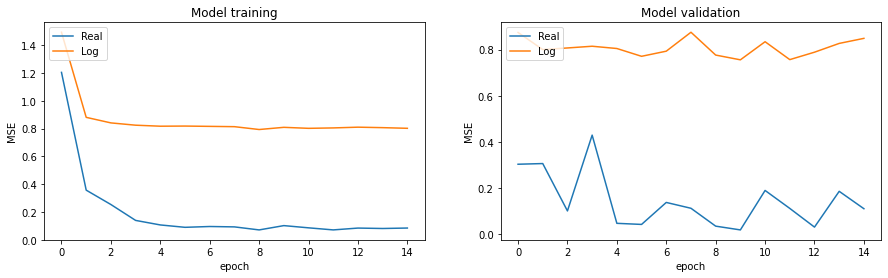

In [ ]:
fig = plt.figure(figsize=(15,4))
ax1 = plt.subplot2grid((1,2),(0,0))
ax1.plot(hist.history['metr'])
ax1.plot(hist.history['loss'])
ax1.set_title('Model training')
ax1.set_ylabel('MSE')
ax1.set_xlabel('epoch')
ax1.legend(['Real', 'Log'], loc='upper left')

ax1 = plt.subplot2grid((1,2),(0,1))
ax1.plot(hist.history['val_metr'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('Model validation')
ax1.set_ylabel('MSE')
ax1.set_xlabel('epoch')
ax1.legend(['Real', 'Log'], loc='upper left')
plt.show()

In [ ]:
#check if the best weights been restored
rnn.evaluate(X_test,y_test)

123/123 [==============================] - 4s 29ms/step - loss: 0.7557 - metr: 0.0189


[0.755744218826294, 0.018938438966870308]

In [ ]:
x=" ping"
text= clean(x)
text= extendedClean(text)
tokenized=text.replace(",", " , ").replace("("," ( ").replace(")"," ) ").replace("="," = ")
X=tokenizer.texts_to_sequences([tokenized])
print(X)
X = pad_sequences(X,244)


[[313]]


In [ ]:
np.exp(rnn.predict(X))

array([[2.7490347e-05]], dtype=float32)

In [ ]:
from google.colab import files

rnn.save('modelRnn.h5')
files.download('modelRnn.h5')
dump(tokenizer, open('tokenizer.pkl', 'wb'))
files.download('tokenizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Result

#### Models Accuracy Log Transformation Applied

SVR : 1,13<br>
BERT: 1,15<br>
RNN:  0,76<br>